In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import glob

# 2021.10.03
读取LS4P中的部分数据进行合并，用于后续绘图

## NJU LS4P_B
单位为 kg*m^-2*s^-1 需要转换到mm/d 乘以86400

In [ ]:
# read mult NC files to select specfic var
NJU_path         = "/raid61/LS4P-TPEMIP/TPEMIP-NJU/"
multfiles_names  = glob.glob(NJU_path + "LS4P_B*/LS4P_STS*.nc")
xr_multfiles     = xr.open_mfdataset(multfiles_names, parallel = True)
pr_nju           = xr_multfiles['pr']*86400 #更改单位 mm
select_dict      = {} # 选定合适年月
time_year        = (pr_nju.time.dt.year >= 1991) # 时次相对较长，一开始使用1998年一年进行尝试
time_month       = (pr_nju.time.dt.month.isin([4,5,6,7,8])) # 时次相对较长，一开始使用1998年一年进行尝试
select_time      = (time_year & time_month)
select_dict['time'] = select_time
# wrtie dask nc files to single files
path_out         = "/raid61/LS4P-TPEMIP/TEMP_DATA/precip/"
pr_nju.sel(select_dict).to_netcdf(path_out + "NJU_LS4P_B_pre.nc")

## NJU LS4P_C
单位为 kg*m^-2*s^-1 需要转换到mm/d 乘以86400

In [ ]:
# read mult NC files to select specfic var
NJU_path         = "/raid61/LS4P-TPEMIP/TPEMIP-NJU/"
multfiles_names  = glob.glob(NJU_path + "LS4P_C*/LS4P_STS*.nc")
xr_multfiles     = xr.open_mfdataset(multfiles_names, parallel = True)
pr_nju           = xr_multfiles['pr']*86400 #更改单位 mm
select_dict      = {} # 选定合适年月
time_year        = (pr_nju.time.dt.year >= 1991) # 时次相对较长，一开始使用1998年一年进行尝试
time_month       = (pr_nju.time.dt.month.isin([4,5,6,7,8])) # 时次相对较长，一开始使用1998年一年进行尝试
select_time      = (time_year & time_month)
select_dict['time'] = select_time
# wrtie dask nc files to single files
path_out         = "/raid61/LS4P-TPEMIP/TEMP_DATA/precip/"
pr_nju.sel(select_dict).to_netcdf(path_out + "NJU_LS4P_C_pre.nc")

## SYS
wrf后处理，需要将累计降水处理为逐日的降水

### 提取变量的中间文件处理部分
因为SYS文件相对较大（6hr间隔）因此预先处理出一个同目录下的文件夹中的中间文件，并用之后再计算逐日的情况

需要将不同的文件进行并发操作，加快dask的写出部分

In [ ]:
# read mult NC files to select specfic var
# sys文件太大，先使用cdo处理出来一批临时文件，再将临时文件进行合并
import os
out_path                   = "/raid61/LS4P-TPEMIP/TEMP_DATA/precip/sys_tempfiles/"  # 存放sys的临时文件
os.system("mkdir -p " + out_path)
files_in_list = []
files_out_list = []
for single_year in range(1991, 2016):
    SYS_path                  = "/raid61/LS4P-TPEMIP/LS4P_TPEMIP_RCM/WRF4.2.1/wrfout-" + str(single_year) + "/"
    multfiles_names       = glob.glob(SYS_path + "LS4P_WRF4.2.1_TPEMIP_Phase1_6hr_*.nc")
    files_in_list.append(multfiles_names)
    files_out_list.append(out_path + str(single_year) + ".nc")

def write_temp_nc(files_in, files_out):
    print("----- dealing " + files_out)
    ds_temp                   = xr.open_mfdataset(files_in[:], combine  = "nested", concat_dim = "Time")[['RAINC','RAINNC','RAINSH']]
    ds_temp.to_netcdf(files_out)

配合mfdataset，并发进行写数据环节，效果还行，将4mins一个文件的速度提升到了2mins一个

In [ ]:
from multiprocessing import Pool
import os, time, random
print('Parent process %s.' % os.getpid())
p = Pool(4)
for i in range(len(files_in_list)):
    p.apply_async(write_temp_nc, args=( (files_in_list[i], files_out_list[i]) ) )
print('Waiting for all subprocesses done...')
p.close()
p.join()
print('All subprocesses done.')

### 逐日数据的计算部分
将WRF中的RAINC RAINNC RAINSH三个变量进行累加，之后计算到日平均，再将累计降水计算为每一天的增量；增量的时间放置在前一个时次

In [ ]:
from os.path import basename
# 整理降水数据
for single_file in files_out_list:
    ds_wrf_sys= xr.open_dataset( single_file )
    # 做差计算每6小时的降水
    mod_pre = {}
    testb = ds_wrf_sys['RAINC'][1:,:,:].assign_coords({"XTIME":ds_wrf_sys['RAINC'][0:-1,:,:].XTIME})
    testa = ds_wrf_sys['RAINC'][0:-1,:,:]
    mod_pre['RAINC'] = testb - testa
    testb = ds_wrf_sys['RAINNC'][1:,:,:].assign_coords({"XTIME":ds_wrf_sys['RAINNC'][0:-1,:,:].XTIME})
    testa = ds_wrf_sys['RAINNC'][0:-1,:,:]
    mod_pre['RAINNC'] = testb - testa
    testb = ds_wrf_sys['RAINSH'][1:,:,:].assign_coords({"XTIME":ds_wrf_sys['RAINSH'][0:-1,:,:].XTIME})
    testa = ds_wrf_sys['RAINSH'][0:-1,:,:]
    mod_pre['RAINSH'] = testb - testa
    mod_pre['pre'] = mod_pre['RAINC'] + mod_pre['RAINNC'] + mod_pre['RAINSH'] # 六小时间隔总降水
    
    # count daily mean precip
    # 原本的时间坐标 XTIME daily_xtime 和XTIME一样大，但是进行了daily的group
    daily_xtime = mod_pre['pre'].XTIME.dt.strftime("%Y-%m-%d")
    mod_pre['dailypre'] = mod_pre['pre'].groupby(daily_xtime).mean("Time") * 4 # 六小时降水处理为24小时的累计降水
    # change dataarry name
    mod_pre['dailypre'].name='dailypre'
    # 从原来group使用的srftime修改为正确的cf格式的时间 到daily_xtime_pd 并创建稳数组XTIME，以便后续作为坐标变量
    daily_xtime_pd = pd.to_datetime(mod_pre['dailypre'].strftime.values)
    XTIME_daily    = xr.DataArray(daily_xtime_pd, name='Time',dims='Time')
    # 修改坐标变量
    mod_pre['dailypre'] = mod_pre['dailypre'].rename({"strftime":"Time"}).assign_coords( {"Time":XTIME_daily} )
    
    # 2D LAT LON 的坐标变量居然没有正确复制，先进行一下时间平均的操作，再assign
    xlat    = mod_pre['pre'].XLAT.groupby(daily_xtime).mean("Time").rename({"strftime":"Time"}).assign_coords( {"Time":XTIME_daily} )
    xlong = mod_pre['pre'].XLONG.groupby(daily_xtime).mean("Time").rename({"strftime":"Time"}).assign_coords( {"Time":XTIME_daily} )
    mod_pre['dailypre'] = mod_pre['dailypre'].assign_coords({"XLAT":xlat, "XLONG":xlong})
    
    # 输出到NC文件
    mod_pre['dailypre'].to_netcdf(out_path +"increment_" +basename( single_file ),'w')

### 合并所有降水数据到一个新dataset中

In [ ]:
path_out         = "/raid61/LS4P-TPEMIP/TEMP_DATA/precip/"
pr_sys = xr.open_mfdataset("/raid61/LS4P-TPEMIP/TEMP_DATA/precip/sys_tempfiles/increment_*.nc")
select_dict      = {} # 选定合适年月
time_year        = (pr_sys.Time.dt.year >= 1991) # 时次相对较长，一开始使用1998年一年进行尝试
time_month       = (pr_sys.Time.dt.month.isin([4,5,6,7,8])) # 时次相对较长，一开始使用1998年一年进行尝试
select_time      = (time_year & time_month)
select_dict['Time'] = select_time
# 冗长的一步，在最后输出前，先将multcoords赋值正确，避免后续维度在进行计算时丢失
pre_temp = pr_sys.sel(select_dict)
pre_temp = pre_temp.assign_coords({"south_north":pre_temp.south_north, "west_east":pre_temp.west_east,"XLAT":pre_temp.XLAT, "XLONG":pre_temp.XLONG})
pre_temp.to_netcdf(path_out + "SYS_pre.nc")

## Yang-ZhouX
daily的rainc和rainnc已经整理好，下面直接修改时间坐标，选取时间段，之后写出

### 读入数据
数据来源有2,daily的RAINNC和RAINC分开存放

In [ ]:
path_YZX               = "/raid61/LS4P-TPEMIP/LS4P_Yang-ZhouX/sf/dailym&monthlym/"
filename_RAINC    = "RAINC_ls4p_itpcasWRF_TPEMIP_dailym_00z0101????-00z3112????.nc"
filename_RAINNC = "RAINNC_ls4p_itpcasWRF_TPEMIP_dailym_00z0101????-00z3112????.nc"
origin_ds = {}
origin_ds['rainc']   = xr.open_mfdataset(path_YZX + filename_RAINC, combine  = "nested", concat_dim = "XTIME")
origin_ds['rainnc'] = xr.open_mfdataset(path_YZX + filename_RAINNC, combine  = "nested", concat_dim = "XTIME")
for var in origin_ds:
    daily_xtime_pd = pd.to_datetime(origin_ds[var].XTIME.values)
    XTIME_daily    = xr.DataArray(daily_xtime_pd, name='Time',dims='Time')
    origin_ds[var]  = origin_ds[var].rename({"XTIME":"Time"}).assign_coords( {"Time":XTIME_daily} )

### 相加计算每日的累计降水

In [ ]:
total_pre = origin_ds['rainc']['RAINC'] + origin_ds['rainnc']['RAINNC']
total_pre = total_pre.rename('dailypre')
select_dict      = {} # 选定合适年月
timesize = []
# for iyear in range(1991, 2016):
time_year        = (total_pre.Time.dt.year >= 1991) # 时次相对较长，一开始使用1998年一年进行尝试
time_month       = (total_pre.Time.dt.month.isin([4,5,6,7,8])) # 时次相对较长，一开始使用1998年一年进行尝试
select_time      = (time_year & time_month)
select_dict['Time'] = select_time
sel_yzx_temp = total_pre.sel(select_dict)

### 去除掉多余的2009年的数据，位置在153 307 461三个时间index的位置

In [ ]:
sel_time          = sel_yzx_temp.Time
time_delete    = ( sel_time.Time.dt.year.isin([2009]) & sel_time.Time.dt.month.isin([4]) )
delete_index   = np.argwhere(time_delete.values == True)[0:3].reshape(3)  # 153 307 461 三个records含有2009年index的数据，显然不合理
inverse_index = np.array( [i for i in range(0,sel_time.shape[0]) if i not in delete_index] )
sel_yzx            = sel_yzx_temp.isel(Time = inverse_index)
path_out         = "/raid61/LS4P-TPEMIP/TEMP_DATA/precip/"
sel_yzx.to_netcdf(path_out + "Yang-ZhouX_pre.nc")

## YSU数据
YSU数据添补充了经纬度坐标,提取daily数据中的pr变量，添加时间维度以及补充的latlon文件中的维度；

In [ ]:
path_in = "/raid61/LS4P-TPEMIP/TPEMIP-YSU/????/EAPL_LS4P_????_daily_d01.nc"
test = xr.open_mfdataset(path_in, concat_dim = "day", combine = "nested")
test['pr']
xlat_xlong = xr.open_dataset("/raid61/LS4P-TPEMIP/TPEMIP-YSU/LS4P_YSU_EAPl_LATLON.nc")

In [ ]:
time = pd.date_range("1991-01-01","2015-12-31", freq="D")
time_da = xr.DataArray(time, name = "time", dims = "time")
correct_time_3825 = time_da.sel(time = time_da.dt.month.isin([4,5,6,7,8]))
pr_temp = test['pr'].rename({"day":"time"}).assign_coords({"time":correct_time_3825})
# 添加multdimensional coords，通过字典来进行添加
add_coords = { "XLONG" : (("lat","lon") , xlat_xlong.XLONG[0,:,:] ), "XLAT" : (("lat","lon") , xlat_xlong.XLAT[0,:,:] ) }
pr_temp = pr_temp.assign_coords( add_coords )

In [ ]:
path_out         = "/raid61/LS4P-TPEMIP/TEMP_DATA/precip/"
pr_temp.to_netcdf(path_out + "YSU_pre.nc")

## JAMSTEC_WRF数据
缺少4月，并且不知道绘制的变量 conpre 和 mppre 是否正确

确认：需要相加conpre mppre 以及单位是mm/hr

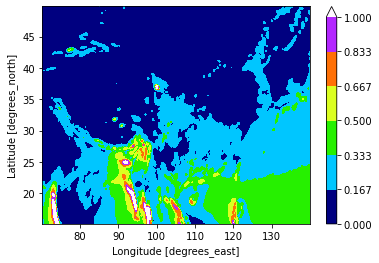

In [75]:
path_in = "/raid61/LS4P-TPEMIP/JAMSTEC_WRF_1991-2015/daily_2D/ncfile/????/conpre_JAMSTECWRF_TPEMIP_day_00z0105????-00z3108????.nc"
conpre = xr.open_mfdataset(path_in)['conpre']
# conpre.mean(dim = 'time').plot.contourf(vmin = 0, vmax = 2, cmap = "gist_ncar")
path_in = "/raid61/LS4P-TPEMIP/JAMSTEC_WRF_1991-2015/daily_2D/ncfile/????/mppre_JAMSTECWRF_TPEMIP_day_00z0105????-00z3108????.nc"
mppre = xr.open_mfdataset(path_in)['mppre']
(mppre+conpre).mean(dim = 'time').plot.contourf(vmin = 0, vmax = 1, cmap = "gist_ncar")

In [71]:
path_out         = "/raid61/LS4P-TPEMIP/TEMP_DATA/precip/"
(conpre + mppre).rename('pr').to_netcdf(path_out + "JAMSTECWRF_pre.nc")

In [115]:
mppre.time

<xarray.DataArray 'time' (time: 3075)>
array(['1991-05-01T00:00:00.000000000', '1991-05-02T00:00:00.000000000',
       '1991-05-03T00:00:00.000000000', ..., '2015-08-29T00:00:00.000000000',
       '2015-08-30T00:00:00.000000000', '2015-08-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1991-05-01 1991-05-02 ... 2015-08-31
Attributes:
    long_name:  Time

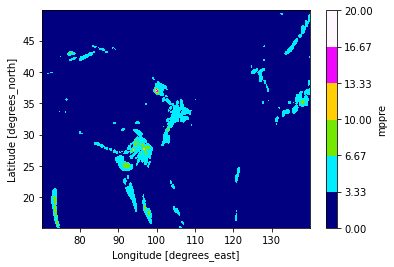

In [109]:
(mppre.mean(dim = 'time')*24).plot.contourf(vmin = 0, vmax = 20, cmap = "gist_ncar")

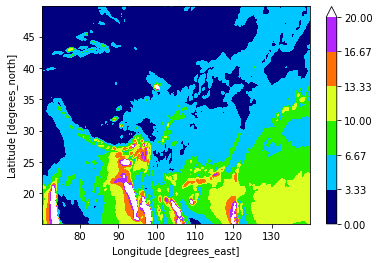

In [139]:
temp_plot = conpre+mppre
plot_data = temp_plot.sel(time = temp_plot.time.dt.month.isin([6,7,8])).mean(dim = 'time')
(plot_data*24).plot.contourf(vmin = 0, vmax = 20, cmap = "gist_ncar")

### 用每月数据代替

In [172]:
monthy_conpre = xr.open_dataset("/raid61/LS4P-TPEMIP/JAMSTEC_WRF_1991-2015/monthy_2D/ncfile/1991/\
conpre_JAMSTECWRF_TPEMIP_mon_00z01051991-00z01081991.nc",decode_times=False)
monthy_mppre = xr.open_dataset("/raid61/LS4P-TPEMIP/JAMSTEC_WRF_1991-2015/monthy_2D/ncfile/1991/\
mppre_JAMSTECWRF_TPEMIP_mon_00z01051991-00z01081991.nc",decode_times=False)

temp_out = (24. * (monthy_conpre['conpre'] + monthy_mppre['mppre'] ) ) 
new_monthy_time = xr.DataArray( pd.date_range("1991-05-01", periods = 4, freq = "MS"), dims = "time", name = "time")
temp_out = temp_out.assign_coords( { "time" : new_monthy_time})
path_out         = "/raid61/LS4P-TPEMIP/TEMP_DATA/precip/"
temp_out = temp_out.rename("pr")
temp_out.to_netcdf(path_out + "JAMSTECWRF_pre.nc")

## CWRF
数据暂时只有平均态，找到了逐月的多年平均，但是是从1980-2016年，相比原本的时段更长

In [69]:
# path_in = "/raid61/LS4P-TPEMIP/TPEMIP-CWRF/Task1/daily/pr_LS4P_CWRF_Task1_day_00z01052003-21z30062003.nc"
# path_in = "/raid61/LS4P-TPEMIP/TPEMIP-CWRF/Task2/" + "pr_LS4P_CWRF_Task2_jun_00z01011980-21z31122016.nc"
path_in = "/raid61/LS4P-TPEMIP/TPEMIP-CWRF/Task2/" + "pr_LS4P_CWRF_Task2_mon_00z01011980-21z31122016.nc"
test  = xr.open_dataset(path_in)
path_out         = "/raid61/LS4P-TPEMIP/TEMP_DATA/precip/"
test['pr'].to_netcdf(path_out + "CWRF_pre.nc")